# Stay connected 
```
var startClickConnect = function startClickConnect(){
    var clickConnect = function clickConnect(){
        console.log("Connnect Clicked - Start");
        document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
        console.log("Connnect Clicked - End"); 
    };

    var intervalId = setInterval(clickConnect, 60000);

    var stopClickConnectHandler = function stopClickConnect() {
        console.log("Connnect Clicked Stopped - Start");
        clearInterval(intervalId);
        console.log("Connnect Clicked Stopped - End");
    };

    return stopClickConnectHandler;
};

var stopClickConnect = startClickConnect();
```

# Memory Information

In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.69GB
Available: 11.95GB
Used: 493.04MB
Percentage: 5.8%


# GPU Information

In [ ]:
! nvidia-smi

Thu Feb 25 14:01:26 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Setup**

In [3]:
# install libraries not in Colab
%%capture
!pip install decord
!pip install hickle

In [4]:
!pip install h5py==2.10.0

In [5]:
%tensorflow_version 1.x

import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

TensorFlow 1.x selected.


Using TensorFlow backend.


1.15.2
2.3.1


In [6]:
# standard sci libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


# machine learning libraries
from keras import backend as K
from keras.legacy.interfaces import generate_legacy_interface, recurrent_args_preprocessor
from keras.models import Model, model_from_json
from keras import activations
from keras.layers import Recurrent
from keras.layers import Conv2D, UpSampling2D, MaxPooling2D, Input
from keras.engine import InputSpec
import theano
from torchvision import transforms as trn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

# image & video libraries
from decord import VideoReader  
from PIL import Image   

# file libraries
import glob
import os
import pickle
import hickle
import h5py
import tqdm

In [7]:
# random number generators for reproducibility
seed = 24

tf.random.set_random_seed(seed)
np.random.seed(seed)

# **Data loading**

In [6]:
# download dataset from dropbox
dropbox_link = 'https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=0'
os.environ['download_link'] = dropbox_link  
!echo $download_link 
!wget -O participants_data.zip -c $download_link
!wget -c https://raw.githubusercontent.com/Neural-Dynamics-of-Visual-Cognition-FUB/Algonauts2021_devkit/main/class_names_ImageNet.txt

https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=0
--2021-08-13 13:40:33--  https://www.dropbox.com/s/agxyxntrbwko7t1/participants_data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/agxyxntrbwko7t1/participants_data.zip [following]
--2021-08-13 13:40:33--  https://www.dropbox.com/s/raw/agxyxntrbwko7t1/participants_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc37cf85e2d24a0f456b7765cad6.dl.dropboxusercontent.com/cd/0/inline/BUJ2cL2WIiqI2TqHcyjrx25w93zaiut9RQ2stfl79vquHUjCox_gI4nYC3SJBEYka1D35HPHExK3apJ80XK2HYZsXq4hmcglOakGF47mJHYmxgKWoPvYFsRw9IuqEDfbVNnA2lrWfC870kCQim_2ozdk/file# [following]
--2021-08-13 13:40:34--  https://uc37cf85e2d24a0f456b7765cad6.dl.dropboxusercontent.com/c

In [7]:
# unzip data file 
%%capture
!unzip -o participants_data.zip

In [8]:
# download pretrained model
savedir="model_data_keras2"
!mkdir -p -- "$savedir"
!wget https://www.dropbox.com/s/iutxm0anhxqca0z/model_data_keras2.zip?dl=0 -O $savedir/model_data_keras2.zip
!unzip $savedir/model_data_keras2.zip -d $savedir
!rm $savedir/model_data_keras2.zip
!mv $savedir/model_data_keras2/* $savedir
!rm -r $savedir/model_data_keras2

--2021-08-13 13:44:04--  https://www.dropbox.com/s/iutxm0anhxqca0z/model_data_keras2.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/iutxm0anhxqca0z/model_data_keras2.zip [following]
--2021-08-13 13:44:04--  https://www.dropbox.com/s/raw/iutxm0anhxqca0z/model_data_keras2.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc638f34d8f0dd78a35e38d05527.dl.dropboxusercontent.com/cd/0/inline/BUL6OCjttnWMwt86zj1b1RCnGh4rnmrEd6YdXNKfdMXVVv6klzGCa0U04OEingjx_cvOCjNdYrChTBp8UeJCZOSFnnMIgFAkXPUMyrTduOhajNxQObBmYrIkITqMGKhe4SQL1SBsG6QR3ily3tNzF-c4/file# [following]
--2021-08-13 13:44:04--  https://uc638f34d8f0dd78a35e38d05527.dl.dropboxusercontent.com/cd/0/inline/BUL6OCjttnWMwt86zj1b1RCnGh4rnmrEd6YdXNKfdMXVVv6klzGCa0U04O

# **Video preprocessing**

In [8]:
# Colab directory containing videos
video_dir = '/content/AlgonautsVideos268_All_30fpsmax'

# get path of all videos
video_list = glob.glob(video_dir + '/*.mp4')

# sort videos in ascending order
video_list.sort()

print('Total number of videos: ', len(video_list))

Total number of videos:  1102


In [34]:
def sample_video_from_mp4(file, num_frames = 16):
    """This function takes a mp4 video file as input and returns
    an array of uniformly sampled frames.
    
    Args
    ----------
    file : str
        path to mp4 video file
    num_frames : int
        number of frames to select with uniform frame sampling
    
    Returns
    -------
    frames: list of frames as PIL images
    num_frames: number of sampled frames

    """
    
    # read video file
    video = VideoReader(file)

    # get total number of video frames
    total_frames = len(video)

    # create frame indices 
    frame_indices = np.linspace(0, total_frames-1, num_frames, dtype = np.int) 

    video_frames = []

    # fill list of video frames as PIL images
    for i in frame_indices:
      video_frames.append(Image.fromarray(video[i].asnumpy()))

    # convert to numpy array
    video_frames = np.array([np.asarray(f) for f in video_frames])
    
    return video_frames, num_frames


# **Neural network feature extraction**

## Pretrained model

In [10]:
#@title Helper function

legacy_prednet_support = generate_legacy_interface(
    allowed_positional_args=['stack_sizes', 'R_stack_sizes',
                            'A_filt_sizes', 'Ahat_filt_sizes', 'R_filt_sizes'],
    conversions=[('dim_ordering', 'data_format'),
                 ('consume_less', 'implementation')],
    value_conversions={'dim_ordering': {'tf': 'channels_last',
                                        'th': 'channels_first',
                                        'default': None},
                        'consume_less': {'cpu': 0,
                                        'mem': 1,
                                        'gpu': 2}},
    preprocessor=recurrent_args_preprocessor)

In [11]:
#@title PredNet architecture

# Reference: https://arxiv.org/abs/1605.08104, github repo: https://github.com/coxlab/prednet


class PredNet(Recurrent):
    '''PredNet architecture - Lotter 2016.
        Stacked convolutional LSTM inspired by predictive coding principles.

    # Arguments
        stack_sizes: number of channels in targets (A) and predictions (Ahat) in each layer of the architecture.
            Length is the number of layers in the architecture.
            First element is the number of channels in the input.
            Ex. (3, 16, 32) would correspond to a 3 layer architecture that takes in RGB images and has 16 and 32
                channels in the second and third layers, respectively.
        R_stack_sizes: number of channels in the representation (R) modules.
            Length must equal length of stack_sizes, but the number of channels per layer can be different.
        A_filt_sizes: filter sizes for the target (A) modules.
            Has length of 1 - len(stack_sizes).
            Ex. (3, 3) would mean that targets for layers 2 and 3 are computed by a 3x3 convolution of the errors (E)
                from the layer below (followed by max-pooling)
        Ahat_filt_sizes: filter sizes for the prediction (Ahat) modules.
            Has length equal to length of stack_sizes.
            Ex. (3, 3, 3) would mean that the predictions for each layer are computed by a 3x3 convolution of the
                representation (R) modules at each layer.
        R_filt_sizes: filter sizes for the representation (R) modules.
            Has length equal to length of stack_sizes.
            Corresponds to the filter sizes for all convolutions in the LSTM.
        pixel_max: the maximum pixel value.
            Used to clip the pixel-layer prediction.
        error_activation: activation function for the error (E) units.
        A_activation: activation function for the target (A) and prediction (A_hat) units.
        LSTM_activation: activation function for the cell and hidden states of the LSTM.
        LSTM_inner_activation: activation function for the gates in the LSTM.
        output_mode: either 'error', 'prediction', 'all' or layer specification (ex. R2, see below).
            Controls what is outputted by the PredNet.
            If 'error', the mean response of the error (E) units of each layer will be outputted.
                That is, the output shape will be (batch_size, nb_layers).
            If 'prediction', the frame prediction will be outputted.
            If 'all', the output will be the frame prediction concatenated with the mean layer errors.
                The frame prediction is flattened before concatenation.
                Nomenclature of 'all' is kept for backwards compatibility, but should not be confused with returning all of the layers of the model
            For returning the features of a particular layer, output_mode should be of the form unit_type + layer_number.
                For instance, to return the features of the LSTM "representational" units in the lowest layer, output_mode should be specificied as 'R0'.
                The possible unit types are 'R', 'Ahat', 'A', and 'E' corresponding to the 'representation', 'prediction', 'target', and 'error' units respectively.
        extrap_start_time: time step for which model will start extrapolating.
            Starting at this time step, the prediction from the previous time step will be treated as the "actual"
        data_format: 'channels_first' or 'channels_last'.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.

    # References
        - [Deep predictive coding networks for video prediction and unsupervised learning](https://arxiv.org/abs/1605.08104)
        - [Long short-term memory](http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf)
        - [Convolutional LSTM network: a machine learning approach for precipitation nowcasting](http://arxiv.org/abs/1506.04214)
        - [Predictive coding in the visual cortex: a functional interpretation of some extra-classical receptive-field effects](http://www.nature.com/neuro/journal/v2/n1/pdf/nn0199_79.pdf)
    '''
    @legacy_prednet_support
    def __init__(self, stack_sizes, R_stack_sizes,
                 A_filt_sizes, Ahat_filt_sizes, R_filt_sizes,
                 pixel_max=1., error_activation='relu', A_activation='relu',
                 LSTM_activation='tanh', LSTM_inner_activation='hard_sigmoid',
                 output_mode='error', extrap_start_time=None,
                 data_format=K.image_data_format(), **kwargs):
        self.stack_sizes = stack_sizes
        self.nb_layers = len(stack_sizes)
        assert len(R_stack_sizes) == self.nb_layers, 'len(R_stack_sizes) must equal len(stack_sizes)'
        self.R_stack_sizes = R_stack_sizes
        assert len(A_filt_sizes) == (self.nb_layers - 1), 'len(A_filt_sizes) must equal len(stack_sizes) - 1'
        self.A_filt_sizes = A_filt_sizes
        assert len(Ahat_filt_sizes) == self.nb_layers, 'len(Ahat_filt_sizes) must equal len(stack_sizes)'
        self.Ahat_filt_sizes = Ahat_filt_sizes
        assert len(R_filt_sizes) == (self.nb_layers), 'len(R_filt_sizes) must equal len(stack_sizes)'
        self.R_filt_sizes = R_filt_sizes

        self.pixel_max = pixel_max
        self.error_activation = activations.get(error_activation)
        self.A_activation = activations.get(A_activation)
        self.LSTM_activation = activations.get(LSTM_activation)
        self.LSTM_inner_activation = activations.get(LSTM_inner_activation)

        default_output_modes = ['prediction', 'error', 'all']
        layer_output_modes = [layer + str(n) for n in range(self.nb_layers) for layer in ['R', 'E', 'A', 'Ahat']]
        assert output_mode in default_output_modes + layer_output_modes, 'Invalid output_mode: ' + str(output_mode)
        self.output_mode = output_mode
        if self.output_mode in layer_output_modes:
            self.output_layer_type = self.output_mode[:-1]
            self.output_layer_num = int(self.output_mode[-1])
        else:
            self.output_layer_type = None
            self.output_layer_num = None
        self.extrap_start_time = extrap_start_time

        assert data_format in {'channels_last', 'channels_first'}, 'data_format must be in {channels_last, channels_first}'
        self.data_format = data_format
        self.channel_axis = -3 if data_format == 'channels_first' else -1
        self.row_axis = -2 if data_format == 'channels_first' else -3
        self.column_axis = -1 if data_format == 'channels_first' else -2
        super(PredNet, self).__init__(**kwargs)
        self.input_spec = [InputSpec(ndim=5)]

    def compute_output_shape(self, input_shape):
        if self.output_mode == 'prediction':
            out_shape = input_shape[2:]
        elif self.output_mode == 'error':
            out_shape = (self.nb_layers,)
        elif self.output_mode == 'all':
            out_shape = (np.prod(input_shape[2:]) + self.nb_layers,)
        else:
            stack_str = 'R_stack_sizes' if self.output_layer_type == 'R' else 'stack_sizes'
            stack_mult = 2 if self.output_layer_type == 'E' else 1
            out_stack_size = stack_mult * getattr(self, stack_str)[self.output_layer_num]
            out_nb_row = input_shape[self.row_axis] / 2**self.output_layer_num
            out_nb_col = input_shape[self.column_axis] / 2**self.output_layer_num
            if self.data_format == 'channels_first':
                out_shape = (out_stack_size, out_nb_row, out_nb_col)
            else:
                out_shape = (out_nb_row, out_nb_col, out_stack_size)

        if self.return_sequences:
            return (input_shape[0], input_shape[1]) + out_shape
        else:
            return (input_shape[0],) + out_shape

    def get_initial_state(self, x):
        input_shape = self.input_spec[0].shape
        init_nb_row = input_shape[self.row_axis]
        init_nb_col = input_shape[self.column_axis]

        base_initial_state = K.zeros_like(x)  # (samples, timesteps) + image_shape
        non_channel_axis = -1 if self.data_format == 'channels_first' else -2
        for _ in range(2):
            base_initial_state = K.sum(base_initial_state, axis=non_channel_axis)
        base_initial_state = K.sum(base_initial_state, axis=1)  # (samples, nb_channels)

        initial_states = []
        states_to_pass = ['r', 'c', 'e']
        nlayers_to_pass = {u: self.nb_layers for u in states_to_pass}
        if self.extrap_start_time is not None:
           states_to_pass.append('ahat')  # pass prediction in states so can use as actual for t+1 when extrapolating
           nlayers_to_pass['ahat'] = 1
        for u in states_to_pass:
            for l in range(nlayers_to_pass[u]):
                ds_factor = 2 ** l
                nb_row = init_nb_row // ds_factor
                nb_col = init_nb_col // ds_factor
                if u in ['r', 'c']:
                    stack_size = self.R_stack_sizes[l]
                elif u == 'e':
                    stack_size = 2 * self.stack_sizes[l]
                elif u == 'ahat':
                    stack_size = self.stack_sizes[l]
                output_size = stack_size * nb_row * nb_col  # flattened size

                reducer = K.zeros((input_shape[self.channel_axis], output_size)) # (nb_channels, output_size)
                initial_state = K.dot(base_initial_state, reducer) # (samples, output_size)
                if self.data_format == 'channels_first':
                    output_shp = (-1, stack_size, nb_row, nb_col)
                else:
                    output_shp = (-1, nb_row, nb_col, stack_size)
                initial_state = K.reshape(initial_state, output_shp)
                initial_states += [initial_state]

        if keras.backend.backend() == 'theano':
            from theano import tensor as T
            # There is a known issue in the Theano scan op when dealing with inputs whose shape is 1 along a dimension.
            # In our case, this is a problem when training on grayscale images, and the below line fixes it.
            initial_states = [T.unbroadcast(init_state, 0, 1) for init_state in initial_states]

        if self.extrap_start_time is not None:
            initial_states += [K.variable(0, int if K.backend() != 'tensorflow' else 'int32')]  # the last state will correspond to the current timestep
        return initial_states

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        self.conv_layers = {c: [] for c in ['i', 'f', 'c', 'o', 'a', 'ahat']}

        for l in range(self.nb_layers):
            for c in ['i', 'f', 'c', 'o']:
                act = self.LSTM_activation if c == 'c' else self.LSTM_inner_activation
                self.conv_layers[c].append(Conv2D(self.R_stack_sizes[l], self.R_filt_sizes[l], padding='same', activation=act, data_format=self.data_format))

            act = 'relu' if l == 0 else self.A_activation
            self.conv_layers['ahat'].append(Conv2D(self.stack_sizes[l], self.Ahat_filt_sizes[l], padding='same', activation=act, data_format=self.data_format))

            if l < self.nb_layers - 1:
                self.conv_layers['a'].append(Conv2D(self.stack_sizes[l+1], self.A_filt_sizes[l], padding='same', activation=self.A_activation, data_format=self.data_format))

        self.upsample = UpSampling2D(data_format=self.data_format)
        self.pool = MaxPooling2D(data_format=self.data_format)

        self.trainable_weights = []
        nb_row, nb_col = (input_shape[-2], input_shape[-1]) if self.data_format == 'channels_first' else (input_shape[-3], input_shape[-2])
        for c in sorted(self.conv_layers.keys()):
            for l in range(len(self.conv_layers[c])):
                ds_factor = 2 ** l
                if c == 'ahat':
                    nb_channels = self.R_stack_sizes[l]
                elif c == 'a':
                    nb_channels = 2 * self.stack_sizes[l]
                else:
                    nb_channels = self.stack_sizes[l] * 2 + self.R_stack_sizes[l]
                    if l < self.nb_layers - 1:
                        nb_channels += self.R_stack_sizes[l+1]
                in_shape = (input_shape[0], nb_channels, nb_row // ds_factor, nb_col // ds_factor)
                if self.data_format == 'channels_last': in_shape = (in_shape[0], in_shape[2], in_shape[3], in_shape[1])
                with K.name_scope('layer_' + c + '_' + str(l)):
                    self.conv_layers[c][l].build(in_shape)
                self.trainable_weights += self.conv_layers[c][l].trainable_weights

        self.states = [None] * self.nb_layers*3

        if self.extrap_start_time is not None:
            self.t_extrap = K.variable(self.extrap_start_time, int if K.backend() != 'tensorflow' else 'int32')
            self.states += [None] * 2  # [previous frame prediction, timestep]

    def step(self, a, states):
        r_tm1 = states[:self.nb_layers]
        c_tm1 = states[self.nb_layers:2*self.nb_layers]
        e_tm1 = states[2*self.nb_layers:3*self.nb_layers]

        if self.extrap_start_time is not None:
            t = states[-1]
            a = K.switch(t >= self.t_extrap, states[-2], a)  # if past self.extrap_start_time, the previous prediction will be treated as the actual

        c = []
        r = []
        e = []

        # Update R units starting from the top
        for l in reversed(range(self.nb_layers)):
            inputs = [r_tm1[l], e_tm1[l]]
            if l < self.nb_layers - 1:
                inputs.append(r_up)

            inputs = K.concatenate(inputs, axis=self.channel_axis)
            i = self.conv_layers['i'][l].call(inputs)
            f = self.conv_layers['f'][l].call(inputs)
            o = self.conv_layers['o'][l].call(inputs)
            _c = f * c_tm1[l] + i * self.conv_layers['c'][l].call(inputs)
            _r = o * self.LSTM_activation(_c)
            c.insert(0, _c)
            r.insert(0, _r)

            if l > 0:
                r_up = self.upsample.call(_r)

        # Update feedforward path starting from the bottom
        for l in range(self.nb_layers):
            ahat = self.conv_layers['ahat'][l].call(r[l])
            if l == 0:
                ahat = K.minimum(ahat, self.pixel_max)
                frame_prediction = ahat

            # compute errors
            e_up = self.error_activation(ahat - a)
            e_down = self.error_activation(a - ahat)

            e.append(K.concatenate((e_up, e_down), axis=self.channel_axis))

            if self.output_layer_num == l:
                if self.output_layer_type == 'A':
                    output = a
                elif self.output_layer_type == 'Ahat':
                    output = ahat
                elif self.output_layer_type == 'R':
                    output = r[l]
                elif self.output_layer_type == 'E':
                    output = e[l]

            if l < self.nb_layers - 1:
                a = self.conv_layers['a'][l].call(e[l])
                a = self.pool.call(a)  # target for next layer

        if self.output_layer_type is None:
            if self.output_mode == 'prediction':
                output = frame_prediction
            else:
                for l in range(self.nb_layers):
                    layer_error = K.mean(K.batch_flatten(e[l]), axis=-1, keepdims=True)
                    all_error = layer_error if l == 0 else K.concatenate((all_error, layer_error), axis=-1)
                if self.output_mode == 'error':
                    output = all_error
                else:
                    output = K.concatenate((K.batch_flatten(frame_prediction), all_error), axis=-1)

        states = r + c + e
        if self.extrap_start_time is not None:
            states += [frame_prediction, t + 1]
        return output, states

    def get_config(self):
        config = {'stack_sizes': self.stack_sizes,
                  'R_stack_sizes': self.R_stack_sizes,
                  'A_filt_sizes': self.A_filt_sizes,
                  'Ahat_filt_sizes': self.Ahat_filt_sizes,
                  'R_filt_sizes': self.R_filt_sizes,
                  'pixel_max': self.pixel_max,
                  'error_activation': self.error_activation.__name__,
                  'A_activation': self.A_activation.__name__,
                  'LSTM_activation': self.LSTM_activation.__name__,
                  'LSTM_inner_activation': self.LSTM_inner_activation.__name__,
                  'data_format': self.data_format,
                  'extrap_start_time': self.extrap_start_time,
                  'output_mode': self.output_mode}
        base_config = super(PredNet, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


In [12]:
# pretrained weights directory
WEIGHTS_DIR = './model_data_keras2/'

# weights and model files
weights_file = os.path.join(WEIGHTS_DIR, 'tensorflow_weights/prednet_kitti_weights.hdf5')
json_file = os.path.join(WEIGHTS_DIR, 'prednet_kitti_model.json')

In [13]:
# load model weights
with open(json_file, 'r') as f:
    json_string = f.read()
    print(json_string)

train_model = model_from_json(json_string, custom_objects = {'PredNet': PredNet})
train_model.load_weights(weights_file)

{"class_name": "Model", "keras_version": "2.0.6", "config": {"layers": [{"class_name": "InputLayer", "config": {"dtype": "float32", "batch_input_shape": [null, 10, 3, 128, 160], "name": "input_1", "sparse": false}, "inbound_nodes": [], "name": "input_1"}, {"class_name": "PredNet", "config": {"dtype": "float32", "trainable": true, "pixel_max": 1.0, "Ahat_filt_sizes": [3, 3, 3, 3], "return_state": false, "R_filt_sizes": [3, 3, 3, 3], "unroll": false, "batch_input_shape": [null, null, null], "LSTM_inner_activation": "hard_sigmoid", "output_mode": "error", "stateful": false, "error_activation": "relu", "A_activation": "relu", "A_filt_sizes": [3, 3, 3], "stack_sizes": [3, 48, 96, 192], "name": "prednet_1", "R_stack_sizes": [3, 48, 96, 192], "data_format": "channels_first", "implementation": 0, "extrap_start_time": null, "go_backwards": false, "return_sequences": true, "LSTM_activation": "tanh"}, "inbound_nodes": [[["input_1", 0, 0, {}]]], "name": "prednet_1"}, {"class_name": "TimeDistribute

In [14]:
# set parameters
batch_size = 1
nt = 16   # time steps/frames

In [15]:
# model configuration
layer_config = train_model.layers[1].get_config()
layer_config['output_mode'] = 'error'      ########## change output mode ###########
data_format = layer_config['data_format'] if 'data_format' in layer_config else layer_config['dim_ordering']
test_prednet = PredNet(weights=train_model.layers[1].get_weights(), **layer_config)
input_shape = list(train_model.layers[0].batch_input_shape[1:])
input_shape[0] = nt
inputs = keras.Input(shape=tuple(input_shape))
predictions = test_prednet(inputs)
test_model = Model(inputs=inputs, outputs=predictions)

### Example prediction

In [ ]:
example_frames, num_frames = sample_video_from_mp4(video_list[550])

# preprocess example frames
example_frames = example_frames/255
example_frames = tf.image.resize(example_frames, (128, 160))
example_frames = tf.expand_dims(example_frames, axis = 0)
example_frames = tf.transpose(example_frames, (0, 1, 4, 2, 3))
example_frames = example_frames.eval(session=tf.compat.v1.Session())

In [ ]:
# predict
X_hat = test_model.predict(example_frames, batch_size)

In [ ]:
example_frames = np.transpose(example_frames, axes=(0,1,3,4,2))
example_frames.shape

(1, 16, 128, 160, 3)

In [ ]:
X_hat = np.transpose(example_frames, axes=(0,1,2,3,4))
X_hat.shape

(1, 16, 128, 160, 3)

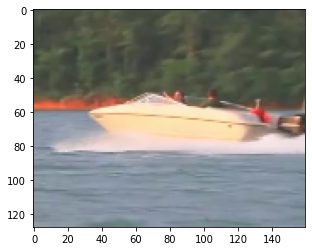

In [ ]:
plt.imshow(example_frames[0,14])

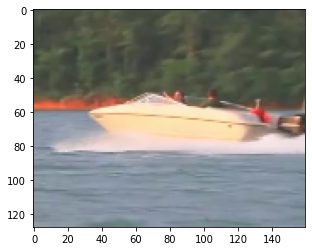

In [ ]:
plt.imshow(X_hat[0,14])

## Model activations

In [58]:
def get_activations(model, video_list, batch_size=1):
    """This function extracts the activations (features) of a specific layer of
    a model to a set of videos and save them in a specified directory. Every
    file is a list with a vector containing the activations of that layer to
    a particular video. The activations are averaged over the frames of every
    video. 

    Parameters
    ----------
    model :
        pytorch model.
    video_list : list
        list containing path to all videos.
    save_dir : str
        save path for extracted activations.
    layer : int
        integer specifying layer number.
    """

    activations = np.zeros((len(video_list), 4))

    for i, video in enumerate(video_list):
        print(f"Processing video #{i}")

        video_frames, num_frames = sample_video_from_mp4(video)

        # preprocess video frames
        video_frames = video_frames / 255.0
        video_frames = np.array([cv2.resize(video_frames[frame], (128, 160)) for frame in range(num_frames)])            
        video_frames = np.expand_dims(video_frames, axis = 0)
        video_frames = np.transpose(video_frames, (0, 1, 4, 3, 2))

        # pass video frames through the model
        layer_errors = model.predict(video_frames, batch_size)
        
        del video_frames

        # average layer activations/errors across frames
        layer_errors = layer_errors.squeeze(axis=0)
        avg_activations = np.sum(layer_errors, axis=0)/float(num_frames)
        
        activations[i] = avg_activations

    return activations


In [60]:
# create saving directory for activations
activations_dir = "/content/activations_prednet"
if not os.path.exists(activations_dir):
  os.makedirs(activations_dir)

activations = get_activations(test_model, video_list)

Processing video #0
Processing video #1
Processing video #2
Processing video #3
Processing video #4
Processing video #5
Processing video #6
Processing video #7
Processing video #8
Processing video #9
Processing video #10
Processing video #11
Processing video #12
Processing video #13
Processing video #14
Processing video #15
Processing video #16
Processing video #17
Processing video #18
Processing video #19
Processing video #20
Processing video #21
Processing video #22
Processing video #23
Processing video #24
Processing video #25
Processing video #26
Processing video #27
Processing video #28
Processing video #29
Processing video #30
Processing video #31
Processing video #32
Processing video #33
Processing video #34
Processing video #35
Processing video #36
Processing video #37
Processing video #38
Processing video #39
Processing video #40
Processing video #41
Processing video #42
Processing video #43
Processing video #44
Processing video #45
Processing video #46
Processing video #47
Pr

## Perform PCA on activations

In [ ]:
def do_PCA_and_save(activations_dir, save_dir): 
    """This function preprocesses a neural network's features using PCA and
    save the results in a specified directory.

    Parameters
    ----------
    activations_dir : str
        save path for extracted activations.
    save_dir : str
        save path for extracted PCA features.
    """

    # number of PCA components
    n_components = 100     
        
    # get path of activations of a layer to all videos
    activations_file_list = glob.glob(activations_dir + '/*.npy')
    # sort activations in ascending order
    activations_file_list.sort()
    # load one activation to later get dimension
    feature_dim = np.load(activations_file_list[0], allow_pickle=True)[0][0].shape[0]
        
    # initialise data matrix for PCA - #videos x layer dimension
    x = np.zeros((len(activations_file_list), feature_dim))
        
    # fill matrix with activations of every video (for a given layer)
    for i, video_activations in enumerate(activations_file_list):
        temp = np.load(video_activations, allow_pickle=True)[0][0].detach().numpy()
        x[i,:] = temp
        
    # train-test split
    x_train = x[:1000,:]
    x_test = x[1000:,:]

    print("Scaling data")
    # scale training and test sets
    x_train = StandardScaler().fit_transform(x_train)
    x_test = StandardScaler().fit_transform(x_test)

    print("Fitting PCA")
    # find principal components of training set
    pca = PCA(n_components = n_components, random_state = seed)
    pca.fit(x_train)

    print("Projecting data onto components")
    # project data onto components - #videos x #components 
    x_train = pca.transform(x_train)
    x_test = pca.transform(x_test)

    print("Saving")
    # create saving directory
    train_save_path = os.path.join(save_dir, "train_layer_19")  ############ SPECIFY LAYER NUMBER #######
    test_save_path = os.path.join(save_dir, "test_layer_19")

    # save results
    np.save(train_save_path, x_train)
    np.save(test_save_path, x_test)
        

In [ ]:
# create saving directory for pca features
pca_dir = '/content/pca_activations'
if not os.path.exists(pca_dir):
  os.makedirs(pca_dir)

# call function to get dimensionality-reduced activations
do_PCA_and_save(activations_dir, pca_dir)

Scaling data
Fitting PCA
Projecting data onto components
Saving


# **Regression on fMRI data**

In [63]:
# train-test split
train_activations = activations[:1000]
test_activations = activations[1000:]

In [64]:
train_activations.shape

(1000, 4)

In [65]:
test_activations.shape

(102, 4)

In [66]:
#@title Helper functions for data loading


# loading function for pickle ROI file
def load_dict(filename_):
    # read file in bytes
    with open(filename_, 'rb') as f:
        # create pickle object
        u = pickle._Unpickler(f)
        # # change encoding appropriate for numpy array
        u.encoding = 'latin1'
        # load it
        ret_di = u.load()
        
    return ret_di


def get_fmri(fmri_dir, sub, ROI):
    """This function loads fMRI data into a numpy array for a given
    participant and ROI.
    
    Parameters
    ----------
    fmri_dir : str
        path to fMRI data.
    sub : str
        participant number path
    ROI : str
        name of ROI.

    Returns
    ---------
    np.array
        matrix of dimensions #train_vids x #repetitions x #voxels
        containing fMRI responses to train videos of a given ROI.
    """

    # Load ROI data
    ROI_file = os.path.join(fmri_dir, sub, ROI + ".pkl")
    ROI_data = load_dict(ROI_file)

    # averaging ROI data across repetitions
    ROI_data_train = np.mean(ROI_data["train"], axis = 1)

    return ROI_data_train


def get_activations(activations_dir, layer_name):
    """This function loads neural network features/activations (preprocessed
    using PCA) into a numpy array according to a given layer.
    
    Parameters
    ----------
    activations_dir : str
        path to PCA/processed neural network features
    layer_name : str
        which layer of the neural network to load
    
    Returns
    ---------
    train_activations : np.array
        matrix of dimensions #train_vids x #pca_components
        containing activations of train videos
    """

    # load training and test file of a given layer
    train_file = os.path.join(activations_dir,"train_" + layer_name + ".npy")
    #test_file = os.path.join(activations_dir,"test_" + layer_name + ".npy")
    train_activations = np.load(train_file)
    #test_activations = np.load(test_file)

    # scale training and test activations
    scaler = StandardScaler()
    train_activations = scaler.fit_transform(train_activations)
    #test_activations = scaler.fit_transform(test_activations)

    return train_activations

In [67]:
#@title Correlation function for model validation

def vectorized_correlation(x,y):
    dim = 0

    centered_x = x - x.mean(axis=dim, keepdims=True)
    centered_y = y - y.mean(axis=dim, keepdims=True)

    covariance = (centered_x * centered_y).sum(axis=dim, keepdims=True)

    bessel_corrected_covariance = covariance / (x.shape[dim] - 1)

    x_std = x.std(axis=dim, keepdims=True)+1e-8
    y_std = y.std(axis=dim, keepdims=True)+1e-8

    corr = bessel_corrected_covariance / (x_std * y_std)

    return corr.ravel()

In [74]:
def perform_encoding(train_activations, fmri_dir, sub, ROI, batch_size=1000):
  """This function linearly regresses pca-reduced features/activations of a
  given layer of a neural network to the fMRI activity of a given brain region
  (ROI) in a given subject. The fitted model is used to predict part of the
  training set (validation mode). The model predictions are saved in a specified
  directory. 
  
  # Arguments
  -------------
  pca_dir : str
      path to PCA features.
  fmri_dir : str
      path to fMRI data.
  results_dir : str
      saving directory for results.
  layer : str
      layer name from which to extract activations.
  sub : str
      participant number path.
  ROI : str
      region of interest (brain region) from which to extract fMRI data.
  batch_size : int
      Number of voxels processed when fitting the linear regressor. 1000 by
      default.

  """

  # scale train activations
  scaler = StandardScaler()
  train_activations = scaler.fit_transform(train_activations)
  
  # load fMRI data for a given subject and ROI
  fmri_train_all = get_fmri(fmri_dir, sub, ROI)
  # get number of voxels for given ROI
  num_voxels = fmri_train_all.shape[1]

  # create training and validation sets
  val_activations = train_activations[900:,:]       ################ adjust splits according to #videos ###############
  train_activations = train_activations[:900,:]    
  fmri_train = fmri_train_all[:900,:]
  fmri_val = fmri_train_all[900:,:]      

  # initialise results - #validation videos x #voxels
  pred_fmri = np.zeros_like(fmri_val)

  # perform multiple multivariate regression
  reg = MultiOutputRegressor(LinearRegression()).fit(train_activations, fmri_train)
  pred_fmri = reg.predict(val_activations)
  
  # correlation between validation predictions and ground truth
  corr = vectorized_correlation(fmri_val, pred_fmri)
  print("----------------------------------------------------------------------------")
  # get mean correlation
  voxelwise_corr = round(corr.mean(), 6)
  print("Mean correlation for ROI : ",ROI," in ",sub," using prediction errors is :", voxelwise_corr)

  return voxelwise_corr


In [69]:
# specify create fmri directory
fmri_dir = '/content/participants_data_v2021/mini_track' 

# create saving directory for results
prediction_dir = '/content/model_predictions'
if not os.path.exists(prediction_dir):
  os.makedirs(prediction_dir)

In [70]:
# list of subjects, ROIs, model and layers
subs = ["sub01","sub02","sub03","sub04","sub05","sub06","sub07","sub08","sub09","sub10"]  
ROIs = ["V1","V2","V3","V4","LOC","EBA","FFA","STS","PPA"]

In [75]:
# loop across subjects and layers
voxelwise_corrs = np.zeros((len(subs), len(ROIs)))

for i, sub in enumerate(subs):
  for j, ROI in enumerate(ROIs):
    # make prediction
    print("Starting ROI: ", ROI, "sub: ", sub)
    voxelwise_corrs[i, j] = perform_encoding(train_activations,
                                             fmri_dir,
                                             sub = sub,
                                             ROI = ROI)
    print ("Completed ROI: ", ROI, "sub: ", sub)
    print("----------------------------------------------------------------------------")

# create saving directory
all_prediction_dir = os.path.join(prediction_dir, 'mean_correlation_all_subs_all_ROIs_with_prednet')
np.save(all_prediction_dir, voxelwise_corrs)

Starting ROI:  V1 sub:  sub01
----------------------------------------------------------------------------
Mean correlation for ROI :  V1  in  sub01  using prediction errors is : 0.133514
Completed ROI:  V1 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V2 sub:  sub01
----------------------------------------------------------------------------
Mean correlation for ROI :  V2  in  sub01  using prediction errors is : 0.131445
Completed ROI:  V2 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V3 sub:  sub01
----------------------------------------------------------------------------
Mean correlation for ROI :  V3  in  sub01  using prediction errors is : 0.126542
Completed ROI:  V3 sub:  sub01
----------------------------------------------------------------------------
Starting ROI:  V4 sub:  sub01
----------------------------------------------------------------------------
Mean 

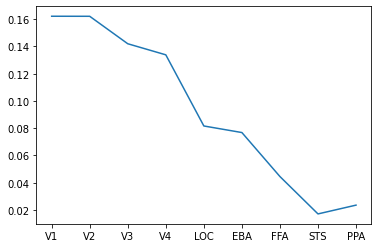

In [76]:
subjs_mean = np.mean(voxelwise_corrs, axis = 0)
subjs_std = np.std(voxelwise_corrs, axis = 0)
plt.plot(ROIs, subjs_mean)

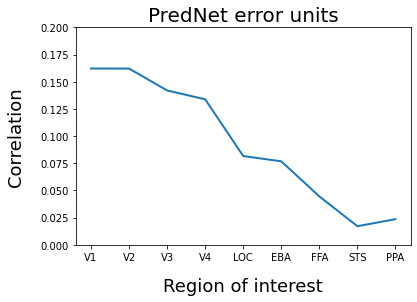

In [78]:
plt.plot(ROIs, subjs_mean, linewidth=2)
plt.title('PredNet error units', fontsize = 20)
plt.xlabel('Region of interest', fontsize=18, labelpad=15)
plt.ylabel('Correlation', fontsize=18, labelpad=15)
plt.ylim([0, 0.2])
plt.savefig('Prediction_with_PredNet_error_units.pdf', bbox_inches='tight')